In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('parser/all_params.csv', sep=',')
df.head()

,Модель,Год,Город,Поколение,Кузов,"Объем двигателя, л",Пробег,Коробка передач,Привод,Руль,Цвет,Растаможен в Казахстане,Опции,Состояние,Цена
0,ВАЗ (Lada) Granta 2190,2014,Астана,2011 - 2018 1 поколение,Седан,1.6 (бензин),NaN,Механика,Передний привод,Слева,NaN,Да,NaN,б/у,2100000
1,ВАЗ (Lada) Granta 2190,2014,Усть-Каменогорск,2011 - 2018 1 поколение,Седан,1.6 (бензин),75 000 км,Механика,Передний привод,Слева,NaN,Да,NaN,б/у,3800000
2,ВАЗ (Lada) Granta 2190,2021,Актобе,2018 - н.в. 1 поколение рестайлинг,Седан,1.6 (бензин),142 230 км,Автомат,Передний привод,Слева,NaN,Да,"тонировка, встроенный телефон, bluetooth, CD-ч...",б/у,4700000
3,ВАЗ (Lada) Granta 2190,2020,Актобе,2018 - н.в. 1 поколение рестайлинг,Седан,1.6 (бензин),138 841 км,Механика,Передний привод,Слева,белый,Да,"литые диски, тонировка, ветровики, дневные ход...",б/у,2860000
4,ВАЗ (Lada) Granta 2190,2016,Атырау,2011 - 2018 1 поколение,Седан,1.6 (бензин),176 000 км,Механика,Передний привод,Слева,коричневый металлик,Да,кондиционер,б/у,2200000


Предобработка

In [5]:
#  Сохраним опции для последующей обработки
options = df['Опции']
print(options)

0                                                     NaN
1                                                     NaN
2       тонировка, встроенный телефон, bluetooth, CD-ч...
3       литые диски, тонировка, ветровики, дневные ход...
4                                             кондиционер
                              ...                        
1868    литые диски, тонировка, ветровики, ксенон, дне...
1869                                                  NaN
1870    аудиосистема, bluetooth, ГУР, ABS, сигнализаци...
1871                                                  NaN
1872                                                  NaN
Name: Опции, Length: 1873, dtype: object


In [6]:
#  Удаляем бесполеные признаки
df_processing = df.drop(['Модель', 'Привод', 'Руль', 'Опции', 'Объем двигателя, л'], axis=1)

#  Вытаскиваем числа из параметра "Пробег"
df_processing['Пробег'] = df_processing['Пробег'].apply(lambda x: int("".join(re.findall(r'\d+', x))) if pd.isna(x) == False else x)

#  Корректируем неверно записаные значения
df_processing.loc[(df_processing['Состояние'] != 'Новая') & (df_processing['Пробег'] < 1000) & (df_processing['Пробег'] > 10), 'Пробег'] *= 1000

#  Удалим пробег меньше 1000 и больше 440 000 (выбросы)
df_processing = df_processing[(df_processing['Пробег'] > 1000) | (df_processing['Пробег'].isna())]
df_processing['Пробег'] = df_processing['Пробег'].apply(lambda k: df_processing['Пробег'].mode()[0] if pd.isna(k) == False and k > 440000 else k)

#  Собираем редкие цвета в одну категорию
color_s = df_processing['Цвет'].value_counts()
rare_color = color_s[color_s < 10]
df_processing['Цвет'] = df_processing['Цвет'].replace(rare_color.index.to_list(), 'редкие')

#  Считаем квантили, и границы межквартильного размаха для цены
Q1 = df['Цена'].quantile(0.25)
Q3 = df['Цена'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

#  Удаляем выбросы в цене

df_processing2 = df_processing[(df_processing['Цена'] < upper) & (df_processing['Цена'] > lower)]

In [7]:
#  Заполняем пропуски "Цвет" на основе вероятностей
probs = df_processing2['Цвет'].value_counts(normalize=True)
df_processing2.loc[:, 'Цвет'] = df_processing2['Цвет'].apply(lambda x: np.random.choice(probs.index, p=probs.values) if pd.isna(x) else x)

In [8]:
df_processing2.shape

(1859, 10)

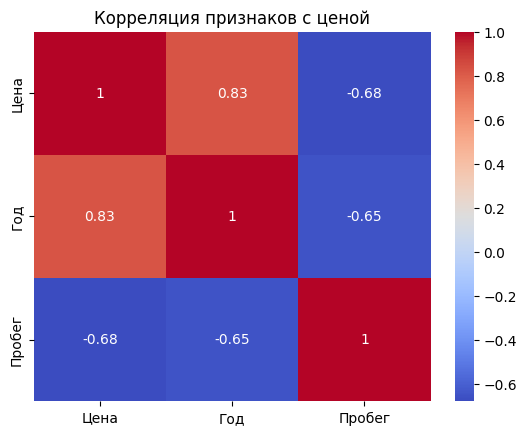

In [9]:
#  Высокая корреляция год и цены с пробегом
price_year_run = df_processing2[['Цена', 'Год', 'Пробег']]
corr = price_year_run.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Корреляция признаков с ценой")
plt.show()

In [10]:
#  Заполняем пропуски "Пробег", на основе линейной модели (год, цена)
dataset_X = df_processing2[df_processing2['Пробег'].notna()][['Цена', 'Год']]
dataset_y = df_processing2[df_processing2['Пробег'].notna()]['Пробег']
dataset_probeg_nan = df_processing2[df_processing2['Пробег'].isna()][['Цена', 'Год']]

X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=0.2, random_state=42)

scaller = StandardScaler()
X_train_std = scaller.fit_transform(X_train)
X_test_std = scaller.transform(X_test)
dataset_probeg_nan_std = scaller.transform(dataset_probeg_nan)

#  Обучаем модель
model_probeg = LinearRegression()
model_probeg.fit(X_train_std, y_train)
y_pred = model_probeg.predict(X_test_std)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mean = y_test.values.sum() / len(y_test)
y_mean = np.full(len(y_test), mean)
mse_mean = mean_squared_error(y_test, y_mean)
rmse_mean = np.sqrt(mse_mean)


#  Делаем предсказания
probeg_pred = model_probeg.predict(dataset_probeg_nan_std)

#  Заполняем пропуски
df_processing3 = df_processing2
df_processing3.loc[df_processing3['Пробег'].isna(), 'Пробег'] = probeg_pred

print(f'Ошибка наивной модели: {rmse_mean}')
print(f'Ошибка линейной модели: {rmse}')

Ошибка наивной модели: 79900.00550909762
Ошибка линейной модели: 56162.2804731454


EDA анализ

In [11]:
#  Кодирование цвета
encod_color = OrdinalEncoder()
df_eda = df_processing3.copy()
df_eda['Цвет энкодер'] = encod_color.fit_transform(df_eda['Цвет'].to_frame())

In [12]:
color_palette = {
    'серебристый': '#C0C0C0',
    'белый': '#FFFFFF',
    'коричневый металлик': '#8B4513',
    'черный': '#2B2B2B',  # Был #000000, стал менее насыщенный
    'белый металлик': '#F5F5F5',
    'серый': '#808080',
    'редкие': '#FFD700',  # Золото для редких цветов
    'серебристый металлик': '#A9A9A9',
    'черный металлик': '#3D3D3D',  # Тоже ослабил насыщенность
    'серый металлик': '#696969',
    'синий': '#0000FF',
    'синий металлик': '#4682B4',
    'коричневый': '#A52A2A'
}

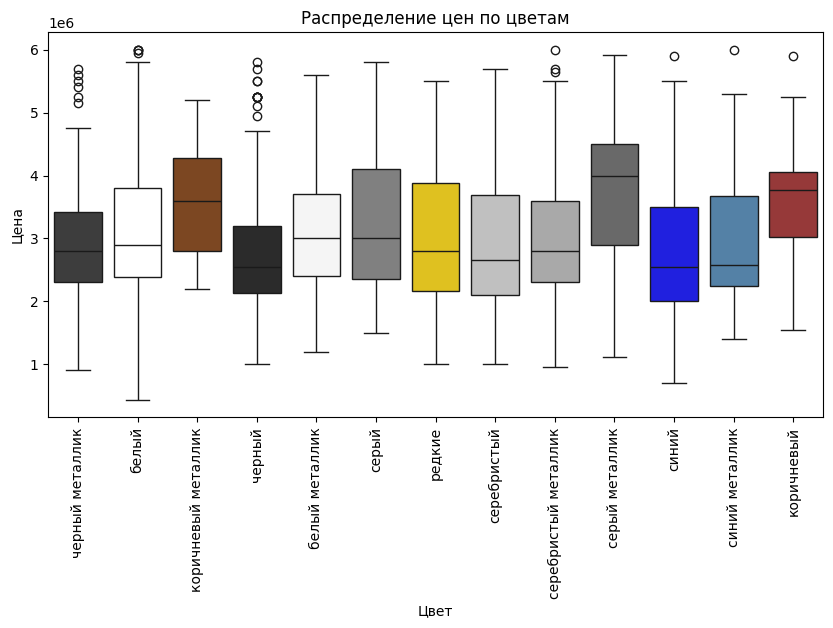

In [13]:
#  Распределение цен по каждому цвету
color_price = df_eda[['Цена', 'Цвет']]
plt.figure(figsize=(10, 5))
sns.boxplot(color_price, y='Цена', x='Цвет', hue='Цвет', palette=color_palette)
plt.title('Распределение цен по цветам')
plt.xticks(rotation=90)
plt.show()

In [14]:
color_count = df_eda['Цвет'].value_counts()
color_count

Цвет
белый                   636
белый металлик          264
черный                  183
черный металлик         139
серебристый металлик    137
серебристый             107
серый металлик           85
редкие                   74
серый                    70
синий металлик           57
синий                    43
коричневый металлик      40
коричневый               24
Name: count, dtype: int64

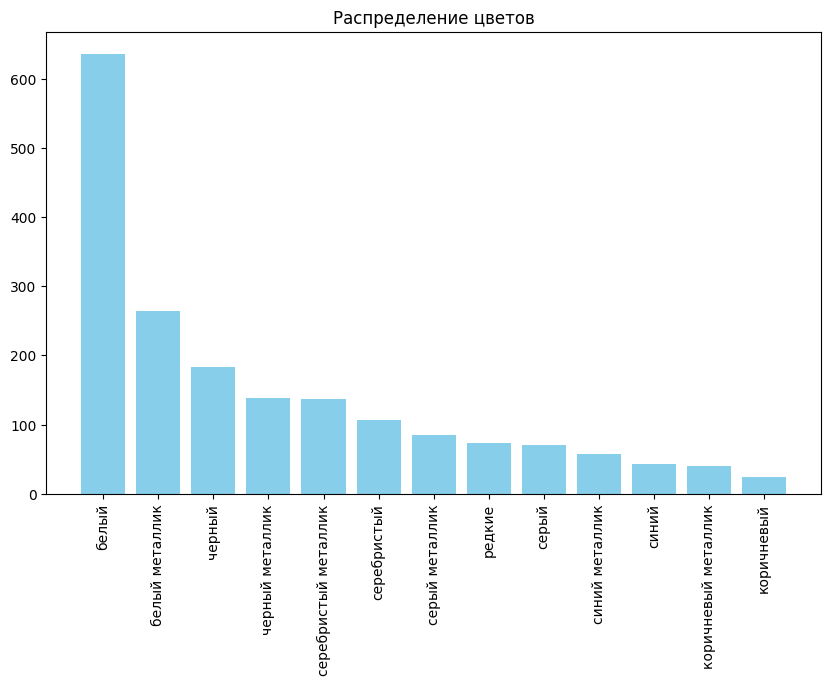

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(color_count.index, color_count, color='skyblue')
plt.xticks(rotation=90, fontsize=10, ha='center')
plt.title('Распределение цветов')
plt.show()

<Figure size 1200x1000 with 0 Axes>

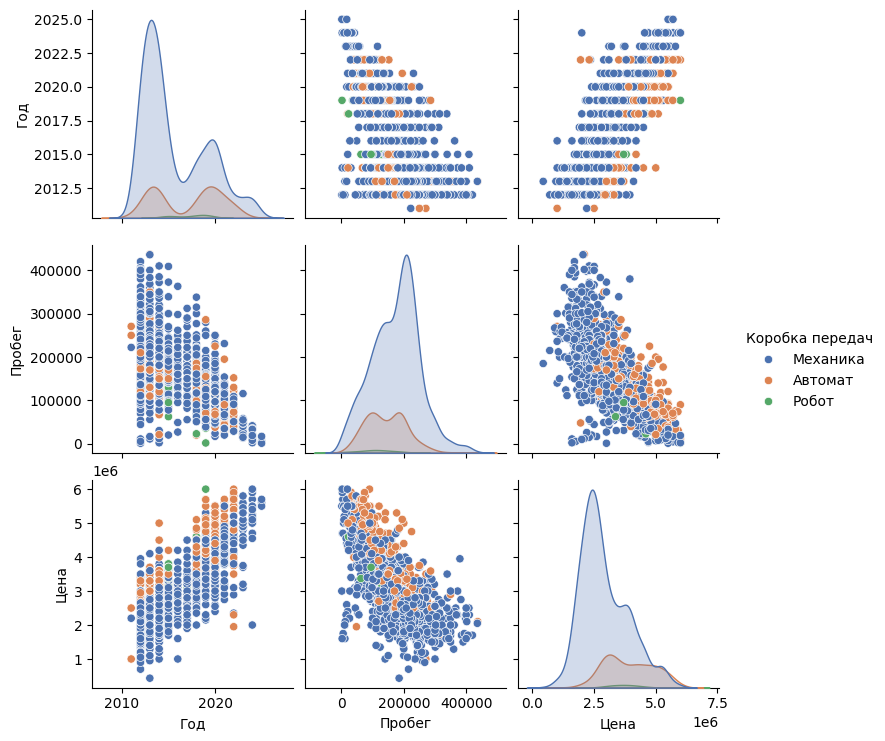

In [16]:
#  Построим графики распределений и рассеяния числовых переменных
color_year_run_trans = df_eda[['Коробка передач', 'Год', 'Пробег', 'Цена']] 
plt.figure(figsize=(12, 10))
sns.pairplot(color_year_run_trans, hue='Коробка передач', palette='deep')

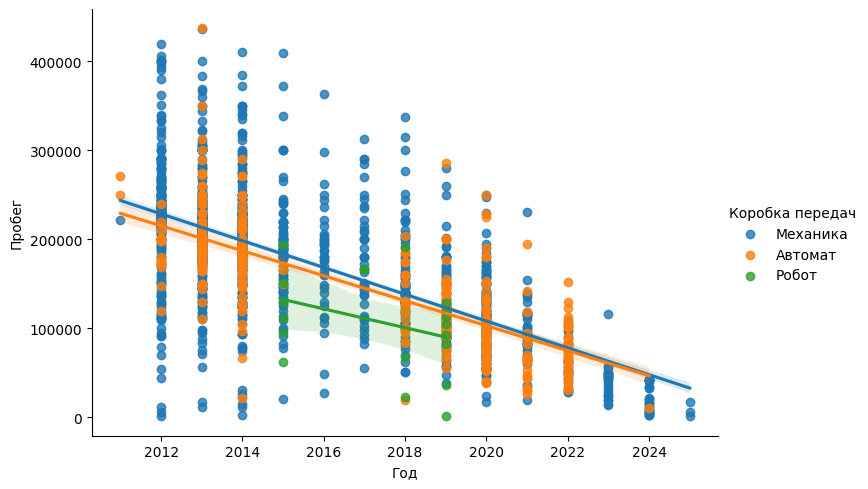

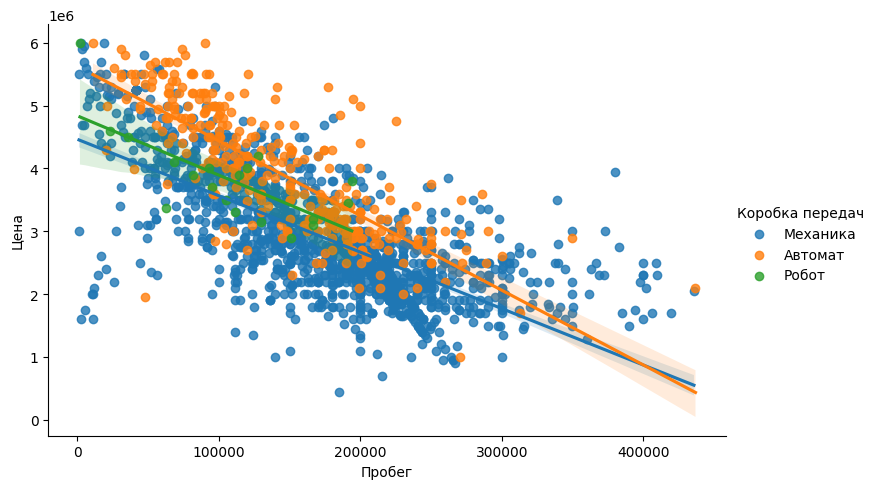

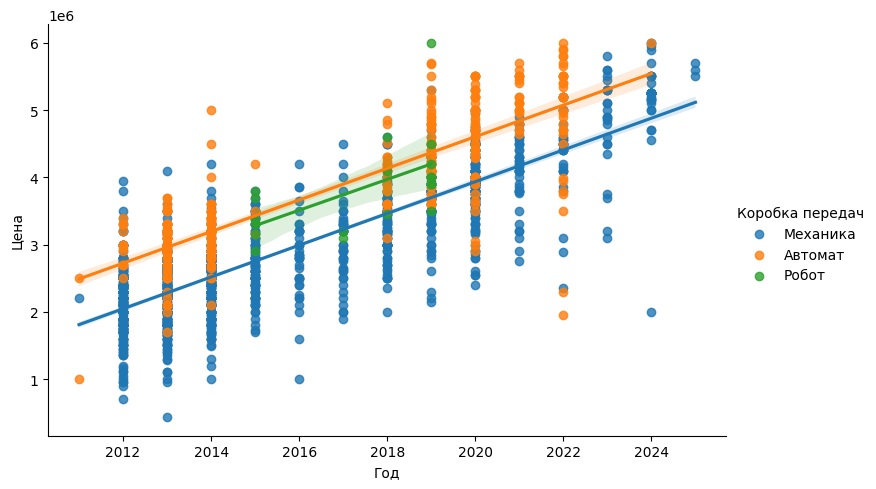

In [17]:
sns.lmplot(x="Год", y="Пробег", data=color_year_run_trans, hue="Коробка передач", aspect=1.5)
sns.lmplot(x="Пробег", y="Цена", data=color_year_run_trans, hue="Коробка передач", aspect=1.5)
sns.lmplot(x="Год", y="Цена", data=color_year_run_trans, hue="Коробка передач", aspect=1.5)
plt.show()

In [18]:
option_notna = df[df['Опции'].notna()].copy()
option_notna['Опции'] = option_notna['Опции'].replace(r',\s{0,2}', ',', regex=True)
option_df = option_notna['Опции'].str.get_dummies(',') #  One-Hot-Encoding

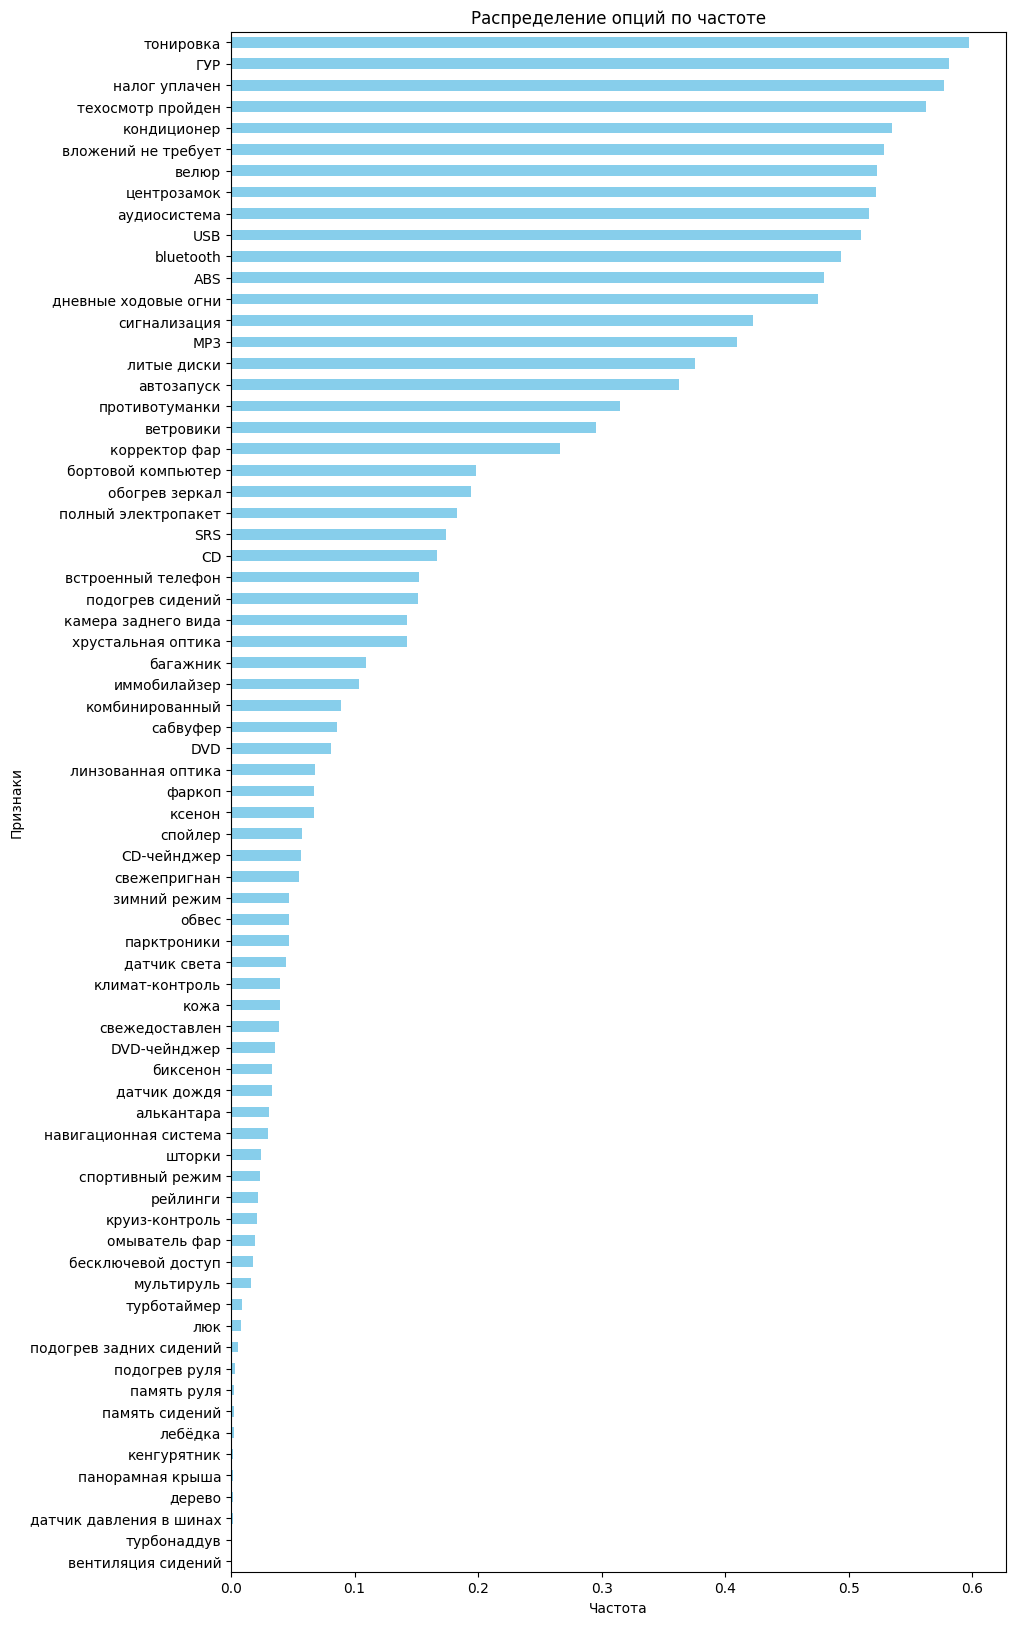

In [19]:
option_count = option_df.mean().sort_values()  # Среднее значение (частота 1)
option_count.plot(kind='barh', figsize=(10, 20), color='skyblue')

plt.xlabel('Частота')
plt.ylabel('Признаки')
plt.title('Распределение опций по частоте')
plt.show()

In [20]:
option_price = pd.concat([option_df, option_notna['Цена']], axis=1)

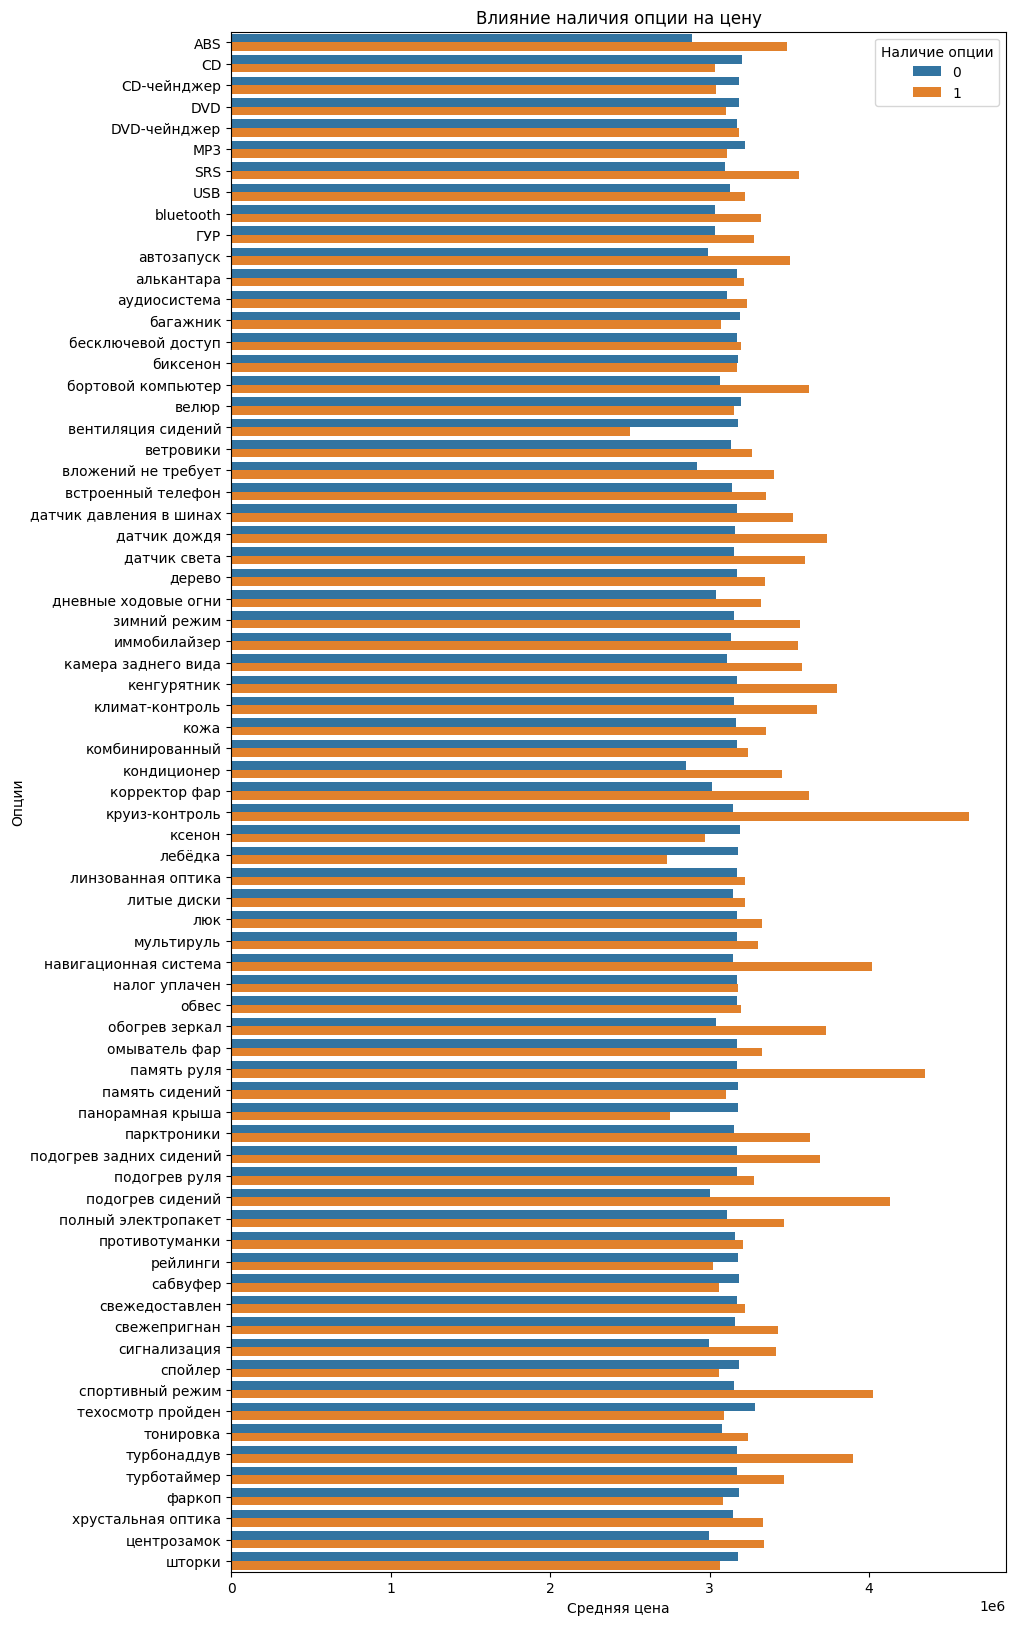

In [21]:
#  Переводим комбинации (опция + наличие + цена) в строки
option_price_melted = option_price.melt(id_vars=['Цена'], var_name='Опция', value_name='Наличие')

#  Разница в цене с учетом наличия опции
plt.figure(figsize=(10, 20))
sns.barplot(data=option_price_melted, x='Цена', y='Опция', hue='Наличие', estimator='mean', errorbar=None)
plt.xlabel('Средняя цена')
plt.ylabel('Опции')
plt.title('Влияние наличия опции на цену')
plt.legend(title="Наличие опции")
plt.show()


In [22]:
option_means_price = option_price.groupby(by=option_price.columns[:-1].to_list())['Цена'].mean().reset_index() 
''' Собираем уникальные комбинации опций, группируем, считаем среднее по столбцу 'Цена'.
    ! Cредние цены по уникальным комбинациям. '''
option_means_price.shape

(1093, 73)

In [23]:
option_means_melt = option_means_price.melt(id_vars=['Цена'], var_name='Опция', value_name='Наличие')
''' Переводим комбинации (опция + наличие + цена) в строки. '''
option_means_melt.shape

(78696, 3)

In [24]:
pivot_table = option_means_melt.pivot_table(index='Опция', columns='Наличие', values='Цена').sort_values(by=1, ascending=False)
''' Делаем сводную таблицу по наличию опций, и считаем среднюю цену. '''

#  Разница в процентах
pivot_table['Разница %'] = (pivot_table[1] - pivot_table[0]) / pivot_table[0] * 100
pivot_table = pivot_table.sort_values(by='Разница %', ascending=False)
pivot_table

Наличие,0,1,Разница %
Опция,,,
круиз-контроль,3.155360e+06,4.626538e+06,46.624741
подогрев сидений,2.993994e+06,4.129570e+06,37.928457
память руля,3.187164e+06,4.350000e+06,36.484960
спортивный режим,3.167574e+06,4.026207e+06,27.106941
навигационная система,3.161382e+06,4.017297e+06,27.074096
...,...,...,...
ксенон,3.207897e+06,2.976905e+06,-7.200731
техосмотр пройден,3.348426e+06,3.099118e+06,-7.445544
панорамная крыша,3.191163e+06,2.750000e+06,-13.824529


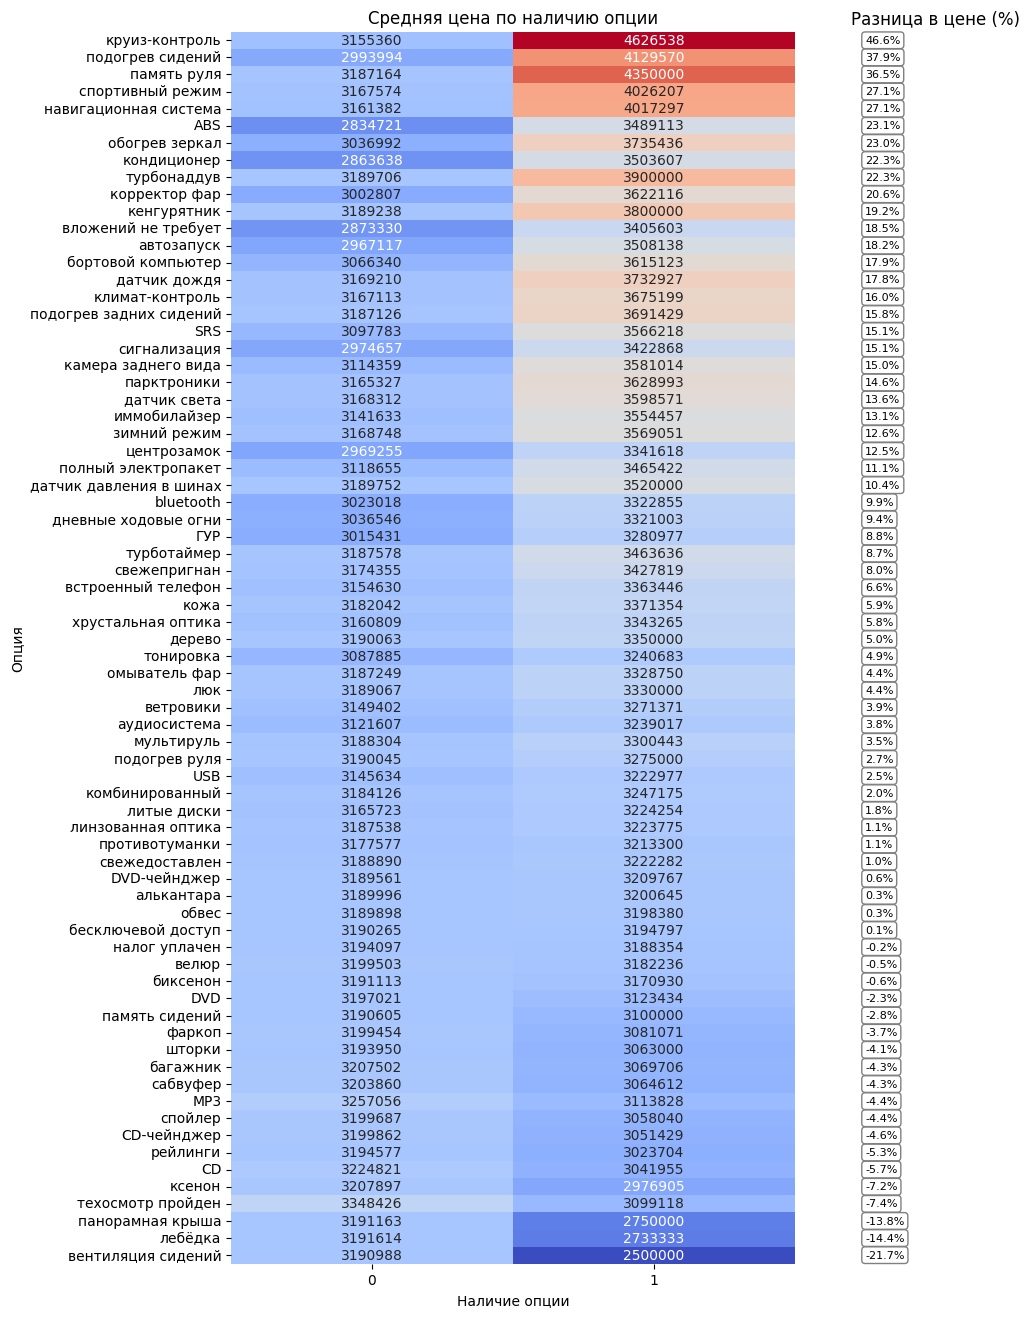

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 16), gridspec_kw={'width_ratios': [4, 1]})  

#  Строим тепловую карту
sns.heatmap(pivot_table.drop('Разница %', axis=1), annot=True, cbar=False, cmap="coolwarm", fmt=".0f", ax=ax1)
ax1.set_title("Средняя цена по наличию опции")
ax1.set_xlabel("Наличие опции")

#  Разница в цене
ax2.set_xlim(0, 1)
ax2.set_ylim(len(pivot_table['Разница %']), 0)
ax2.axis("off")

for i, txt in enumerate(pivot_table['Разница %']):
    ax2.text(0, i + 0.5, f'{txt:.1f}%', ha='left', va='center', fontsize=8, 
             bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

ax2.set_title("Разница в цене (%)")

plt.show()


In [38]:
#  Сохраняем итоговый датасет
df_result = df_processing3.merge(option_df, left_index=True, right_index=True, how="left").fillna(0)
df_result.to_csv('df_result.csv', sep=',', index=False)

In [39]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1859 entries, 0 to 1872
Data columns (total 82 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Год                      1859 non-null   int64  
 1   Город                    1859 non-null   object 
 2   Поколение                1859 non-null   object 
 3   Кузов                    1859 non-null   object 
 4   Пробег                   1859 non-null   float64
 5   Коробка передач          1859 non-null   object 
 6   Цвет                     1859 non-null   object 
 7   Растаможен в Казахстане  1859 non-null   object 
 8   Состояние                1859 non-null   object 
 9   Цена                     1859 non-null   int64  
 10  ABS                      1859 non-null   float64
 11  CD                       1859 non-null   float64
 12  CD-чейнджер              1859 non-null   float64
 13  DVD                      1859 non-null   float64
 14  DVD-чейнджер             1859